# Classify turbines by updraft/downdraft

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy             as np
import math
import pandas as pd
import pickle
import postproamrwindsample as ppsample
import time
import utm
from IPython.display import display, Markdown, Latex

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

def getTurbSubsetXY(csvfile, suffix, xlim=[-np.finfo(np.float64).max, np.finfo(np.float64).max], ylim=[-np.finfo(np.float64).max, np.finfo(np.float64).max]):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        xy = [float(x[1][' x']), float(x[1][' y'])]
        if x[1]['# name'].endswith(suffix) and ((xlim[0] <= xy[0]) and (xy[0]<=xlim[1]) and (ylim[0]<=xy[1]) and (xy[1]<=ylim[1])):
            #print(x[1])
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

def getTurbCategoryList(csvfile, suffix, limitdict):
    allturbs = []
    for box in limitdict['bboxes']:
        turbinbox = getturbnames(getTurbSubsetXY(csvfile, suffix, xlim=box[0], ylim=box[1]))
        allturbs += turbinbox
    return allturbs

def getCartesianMesh(x,y):
    p00=np.array([x[0,0], y[0,0]])
    p10=np.array([x[1,0], y[1,0]])
    p01=np.array([x[0,1], y[0,1]])
    dx=np.linalg.norm(p00-p10)
    dy=np.linalg.norm(p00-p01)
    hhshape=x.shape
    xvec=np.arange(hhshape[1])*dx
    yvec=np.arange(hhshape[0])*dy
    xm, ym = np.meshgrid(xvec, yvec)
    return xm, ym

In [3]:
summitcsv    = '../../UnstableABL_farmrun_turbines.csv'

iplane       = 0
zhh          = 90
rotorD       = 127

In [4]:
KPturbdf = getTurbSubset(summitcsv, '-KP')

In [5]:
# Load the SW  pickle files
picklefile     = 'AllKP_SWplanes_noturb.pkl'
pfile          = open(picklefile, 'rb')
allds_noturb   = pickle.load(pfile)
pfile.close()

picklefile     = 'AllKP_SWplanes_wturb.pkl'
pfile          = open(picklefile, 'rb')
allds_wturb    = pickle.load(pfile)
pfile.close()

In [6]:
turbname = '2019-WTW-4655-KP'
xm, zm =  getCartesianMesh(allds_noturb[turbname]['y'][0,:,:], allds_noturb[turbname]['z'][0,:,:])
zvec=zm[:,0]
zinside = ((zhh-0.5*rotorD <= zvec) & (zvec <= zhh+0.5*rotorD))

In [7]:
def getTotalW(turblist, ds_noturb, ds_wturb, Umin, Umax, xinflow=70, iplane=0):
    returnlist=[]
    totalw = 0
    for turb in turblist:
        ds_pre  = ds_noturb[turb]
        ds_turb = ds_wturb[turb]
        avgw = np.mean(ds_pre['velocityz_avg'][iplane,:,:])
        # Calculate the average U
        Uvec = ds_turb['velocityx_avg'][iplane,:,xinflow]
        Vvec = ds_turb['velocityy_avg'][iplane,:,xinflow]
        Uhvec = np.sqrt(Uvec**2 + Vvec**2)
        avgU = np.mean(Uhvec[zinside])
        if (Uhmin <= avgU) and (avgU <= Uhmax):
            returnlist.append((turb, avgU, avgw))
            totalw += avgw
    return totalw, returnlist

In [8]:
# Classify turbines based on the SW pickle file
Utarget = 9
bound   = 0.1
Uhmin = Utarget*(1-bound)
Uhmax = Utarget*(1+bound)

allturblist = getturbnames(getTurbSubset(summitcsv, '-KP'))
updraftturbs   = []
downdraftturbs = []
fulllist       = []
totalw = 0
for turb in allturblist:
    ds_pre  = allds_noturb[turb]
    ds_turb = allds_wturb[turb]
    # Calculate the average W
    avgw = np.mean(ds_pre['velocityz_avg'][iplane,:,:]) 
    # Calculate the average U
    xinflow = 70
    Uvec = ds_turb['velocityx_avg'][iplane,:,xinflow]
    Vvec = ds_turb['velocityy_avg'][iplane,:,xinflow]
    Uhvec = np.sqrt(Uvec**2 + Vvec**2)
    avgU = np.mean(Uhvec[zinside])
    fulllist.append((turb, avgU, avgw))
    if (Uhmin <= avgU) and (avgU <= Uhmax):
        print('%s %f %f'%(turb, avgw, avgU))
        if avgw > 0.0:
            updraftturbs.append(turb)
        else:
            downdraftturbs.append(turb)
        totalw += avgw

print('Number of turbines in updraft: %i'%len(updraftturbs))
print('Number of turbines in downdraft: %i'%len(downdraftturbs))
print("Averaged W = %f"%(totalw/(len(updraftturbs)+len(downdraftturbs))))

2019-WTW-4713-KP -0.092251 8.645789
2019-WTW-4726-KP -0.095803 9.317388
2019-WTW-4671-KP -0.128354 8.162089
2019-WTW-4715-KP 0.448964 8.222813
2019-WTW-4691-KP 0.301331 8.485427
2019-WTW-7913-KP -0.102486 8.821547
2019-WTW-4694-KP -0.122520 9.447356
2019-WTW-4718-KP 0.066430 8.835714
2019-WTW-4690-KP -0.124008 8.763075
2019-WTW-4656-KP -0.026698 8.143659
2019-WTW-4697-KP -0.111735 8.736650
2019-WTW-4701-KP -0.141329 8.373783
2019-WTW-4723-KP 0.119974 8.709557
2019-WTW-4673-KP -0.381540 9.065556
2019-WTW-4716-KP -0.005966 8.873389
2019-WTW-4693-KP 0.181245 8.311204
2019-WTW-4725-KP -0.256489 9.484592
2019-WTW-7915-KP 0.089495 8.694744
2019-WTW-4689-KP -0.082134 8.476362
2019-WTW-4648-KP -0.120261 8.494697
2019-WTW-4721-KP -0.157111 8.273571
2019-WTW-4652-KP 0.211636 8.148572
2019-WTW-4658-KP -0.149141 8.271045
2019-WTW-4692-KP 0.293034 8.553749
2019-WTW-4702-KP -0.111244 8.925375
2019-WTW-4704-KP -0.179099 8.348049
2019-WTW-7916-KP 0.029589 8.457418
2019-WTW-4711-KP -0.050220 8.322586
2

In [9]:
east     = {'label':'east half',
            'bboxes':[[[639000, 647500], [4022500, 4035000]],
                     ],
            'plotargs':{'linewidth':1, 'edgecolor':'k', 'facecolor':'none', 'ls':'--'}, #{'facecolor':'cyan', 'alpha':0.5}, #{'linewidth':1, 'edgecolor':'r', 'facecolor':'none'}
           }
west     = {'label':'west half',
            'bboxes':[[[629000, 639000], [4022500, 4035000]],
                     ],
            'plotargs':{'linewidth':1, 'edgecolor':'k', 'facecolor':'none', 'ls':'--'}, #{'facecolor':'cyan', 'alpha':0.5}, #{'linewidth':1, 'edgecolor':'r', 'facecolor':'none'}
           }

test     = {'label':'test',
            'bboxes':[[[638700, 647500], [4022500, 4035000]],
                     ],
            'plotargs':{'linewidth':1, 'edgecolor':'r', 'facecolor':'none', 'ls':'--'}, #{'facecolor':'cyan', 'alpha':0.5}, #{'linewidth':1, 'edgecolor':'r', 'facecolor':'none'}
           }

test2     = {'label':'test2',
            'bboxes':[[[634000, 643500], [4022500, 4035000]],
                     ],
            'plotargs':{'linewidth':1, 'edgecolor':'g', 'facecolor':'none', 'ls':'--'}, #{'facecolor':'cyan', 'alpha':0.5}, #{'linewidth':1, 'edgecolor':'r', 'facecolor':'none'}
           }

turbinecategorylist = {}
allcategories = [east, 
                 #west, 
                 test,
                 test2]
for d in allcategories:
    turblist = getTurbCategoryList(summitcsv, '-KP', d)
    d['turblist'] = turblist
    turbinecategorylist[d['label']] = turblist

In [10]:
for d in allcategories:
    allW, tlist = getTotalW(d['turblist'], allds_noturb, allds_wturb, Uhmin, Uhmax, xinflow=70)
    #print(allW/len(tlist), len(tlist))
    Nturbs = len(tlist)
    avgWinBox = allW/Nturbs
    print("%-15s %12.4f %i"%(d['label'], avgWinBox, Nturbs))

east half             0.0028 30
test                 -0.0043 32
test2                -0.0038 40


(629355.1382429501, 648364.04103605, 4021875.0, 4035625.0)

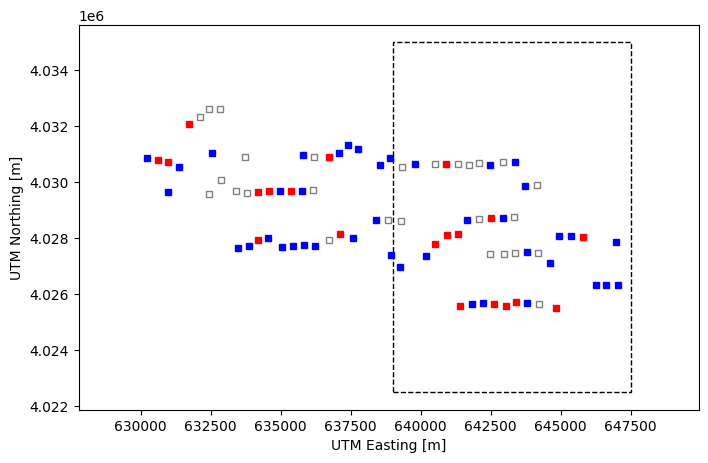

In [16]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,5), facecolor='w', dpi=100)

for x in KPturbdf.iterrows(): 
    name = x[1]['# name']
    if name in updraftturbs:
        plt.plot(float(x[1][' x']), float(x[1][' y']), 'rs', markersize=4)
    elif name in downdraftturbs:
        plt.plot(float(x[1][' x']), float(x[1][' y']), 'bs', markersize=4)
    else:
        plt.plot(float(x[1][' x']), float(x[1][' y']), 's', color='gray', markersize=4, mfc='none')

for grouping in allcategories[:1]:
    plotargs = grouping['plotargs']
    for ibox, box in enumerate(grouping['bboxes']):
        xlims = box[0]
        ylims = box[1]
        kwargs = plotargs.copy()
        if ibox==0: kwargs['label'] = grouping['label']
        rect = patches.Rectangle((xlims[0], ylims[0]), (xlims[1]-xlims[0]), (ylims[1]-ylims[0]),  **kwargs)
        ax.add_patch(rect)

ax.set_xlabel('UTM Easting [m]')
ax.set_ylabel('UTM Northing [m]')
ax.axis('equal')

In [12]:
# Write out the neutral subset
neutrallist = allcategories[0]['turblist']
with open('nodraftturbines.txt', 'w') as f:
    for t in neutrallist:  f.write(f"{t}\n")

In [17]:
# Print out statistics:
allstats = [['All KP turbines', allturblist],
            ['Updraft turbines', updraftturbs],
            ['Downdraft turbines', downdraftturbs],
            ['Flat subset',     neutrallist]
           ]

print("%-20s %12s %10s"%("Category","AVG W vel","Nturbines"))
for subset in allstats:
    allW, tlist = getTotalW(subset[1], allds_noturb, allds_wturb, Uhmin, Uhmax, xinflow=70)
    #print(allW/len(tlist), len(tlist))
    Nturbs = len(tlist)
    avgWinBox = allW/Nturbs
    print("%-20s %12.4f %10i"%(subset[0], avgWinBox, Nturbs))

Category                AVG W vel  Nturbines
All KP turbines           -0.0242         61
Updraft turbines           0.1878         20
Downdraft turbines        -0.1276         41
Flat subset                0.0028         30
